# SMA, Momentum, and Mean Reversion Strategy Backtesting

In [106]:
import pandas as pd
import yfinance as yf
import numpy as np
from scipy.optimize import brute

## SMA Strategies

In [14]:
EU_US = yf.download("EURUSD=X", start="2010-01-04", end="2019-12-31")

[*********************100%***********************]  1 of 1 completed


In [15]:
EU_US.drop(columns = ['Open','High','Low','Close','Volume'], inplace=True)

In [18]:
EU_US.rename(columns = {'Adj Close':'price'},inplace=True)

In [19]:
EU_US['SMA1'] = EU_US['price'].rolling(42).mean()
EU_US['SMA2'] = EU_US['price'].rolling(252).mean()
EU_US.tail()

,price,SMA1,SMA2
Date,,,
2019-12-25,1.109016,1.107967,1.122689
2019-12-26,1.109545,1.107958,1.122568
2019-12-27,1.110112,1.107926,1.122466
2019-12-30,1.118230,1.107992,1.122410
2019-12-31,1.120230,1.108100,1.122343


<AxesSubplot:title={'center':'EUR/USD | 42 & 252 days SMAs'}, xlabel='Date'>

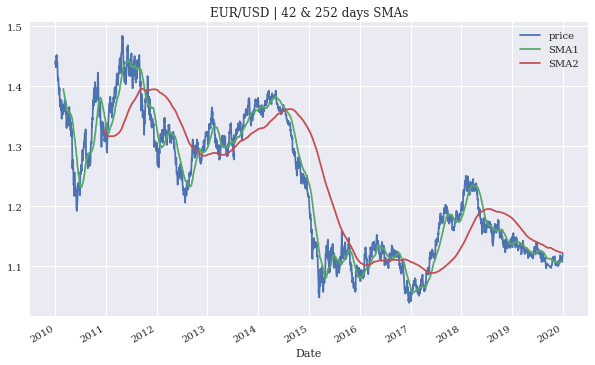

In [21]:
# this is an old style of plotting that should be abandoned
%matplotlib inline
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

EU_US.plot(title='EUR/USD | 42 & 252 days SMAs', figsize=(10,6))

## Now Calculate Signals, or Market Positioning

  * Essence of SMA strategy: Go long when shorter SMA is above the longer one and short when vice versa
  * A long position is indicated by 1 and a short position is indicated by -1

<AxesSubplot:title={'center':'Market Positioning'}, xlabel='Date'>

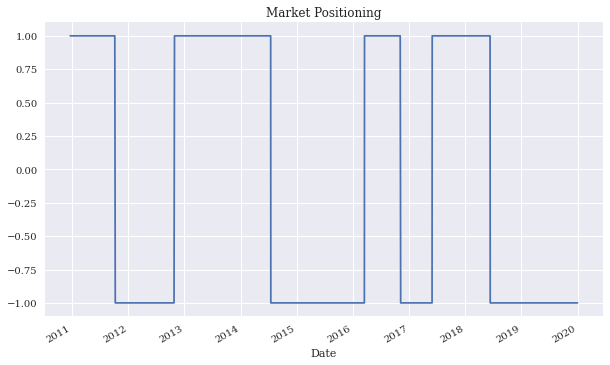

In [26]:
EU_US['position'] = np.where(EU_US['SMA1'] > EU_US['SMA2'], 1, -1)
EU_US.dropna(inplace=True)
EU_US['position'].plot(ylim=[-1.1,1.1],
title='Market Positioning',
figsize=(10,6))

<AxesSubplot:>

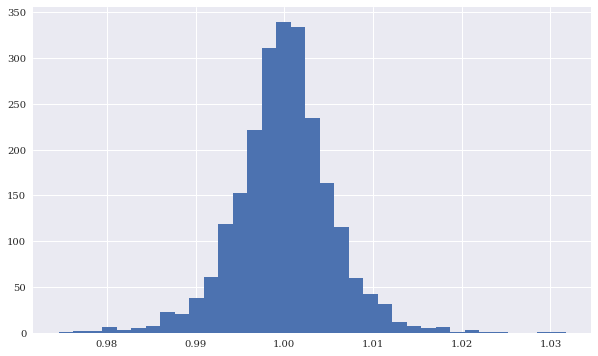

In [49]:
# See Tsay Eqn 1.6
EU_US['log_returns'] = np.log(EU_US['price'].pct_change() + 1)
# plot the "simple gross returns" (in the terminology of Tsay)
np.exp(EU_US['log_returns']).hist(bins=35, figsize=(10,6))

## Now Calculate Strategy's Returns
  * Keep in mind we shift the position column down one time step due to the fact that these are EOD prices. If you get out at the end of the day, you still had a position throughout that day (this is what I think)
  * Also, log returns are additive, so you can just sum them up then exponentiate to get the gross performance (a lot of conflicting terminology with gross return which depends on whether its used in the tax setting or the basic financial theory setting where gross simply means the ratio of a price at a certain time point to the previous time point's price)

In [46]:
# what we're naming strategy here is simply a column of the log returns of when we had a long position
EU_US['strategy'] = EU_US['position'].shift(1) * EU_US['log_returns']

In [48]:
# Lets compare the strategy to the passive investment strategy (look at that difference!)
np.exp(EU_US[['log_returns','strategy']].sum())

log_returns    0.853962
strategy       1.453382
dtype: float64

<AxesSubplot:xlabel='Date'>

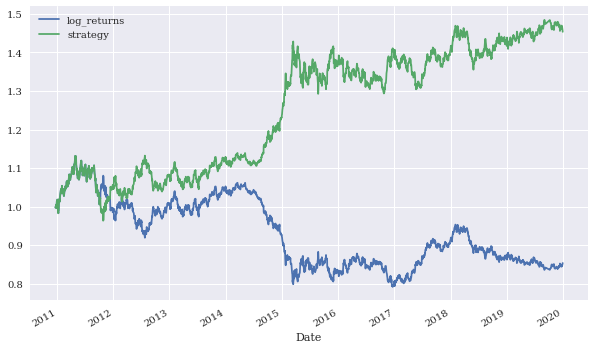

In [86]:
# To get the multiperiod returns at each timestep
np.exp(EU_US[['log_returns','strategy']].cumsum()).plot(figsize=(10,6))


# observe below how the basic SMA strategy kicks ass versus the passive buy and hold strategy.
# Although, this is over a span of 10 years! 

In [58]:
# now estimate the parameters of the returns distributions of the strategy and the currency exchange and "annualize"
# by essentially assuming iid and realizing that the expected return over an investment horizon of such a situation
# is proportional to t and the same goes with the variance (Weiner Process)

# annualized simple return
#np.exp(EU_US[['log_returns','strategy']].mean() * 252) - 1 # this is not the correct formula
(np.exp(EU_US[['log_returns','strategy']]) - 1).mean() * 252

log_returns   -0.013277
strategy       0.044236
dtype: float64

In [54]:
# annualized volatility (not quite sure about)
#np.exp(EU_US[['log_returns','strategy']].std() * np.sqrt(252)) - 1 # this is not the correct formula
(np.exp(EU_US[['log_returns','strategy']]) - 1).std() * np.sqrt(252)

log_returns    0.087152
strategy       0.087128
dtype: float64

## Now Calculate Maximum Drawdown and Longest Drawdown Period

  * maximum drawdown is defined as the maximum drop from peak to trough until a new max peak is obtained

<AxesSubplot:xlabel='Date'>

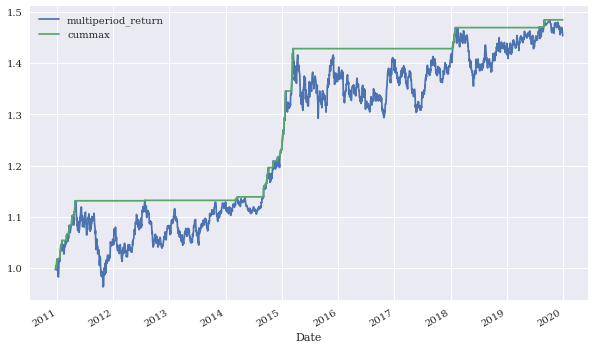

In [59]:
EU_US['multiperiod_return'] = np.exp(EU_US['strategy'].cumsum())
EU_US['cummax'] = EU_US['multiperiod_return'].cummax()
EU_US[['multiperiod_return','cummax']].dropna().plot(figsize=(10,6))

In [60]:
drawdown = EU_US['cummax'] - EU_US['multiperiod_return']
drawdown.max()

0.16787837793155214

In [63]:
# longest drawdown a bit more involved

# temporarily store the maxes
temp = drawdown[drawdown == 0]

# take their difference and then take the max
periods = (temp.index[1:].to_pydatetime() - temp.index[:-1].to_pydatetime())
periods.max()

datetime.timedelta(days=1036)

## Generalized Backtesting Class for SMA Strategy

In [137]:
class SMAVectorBacktester:

    '''
    Attributes
    ----------
    symbol: str
    The ticker to be analyzed
    SMA1: int
    The shorter window moving average window size
    SMA2: int
    The longer window moving average window size
    start: str
    The start date of the security price time series
    end: end
    The end date of the security price time series

    Methods
    -------
    get_data: retrieves and prepares the base data set
    set_parameters: sets one or two new SMA parameters
    run_strategy: runs the backtest for the SMA strategy
    update_and_run: updates SMA parameters and returns the negative performance (for optimization)
    optimize_parameters: brute force optimization for two two SMA ranges
    plot_results: plots the cumulative performace of the trading strategy compared to the symbol
    '''

    def __init__(self, symbol, SMA1, SMA2, start, end):
        self.symbol = symbol
        self.SMA1 = SMA1
        self.SMA2 = SMA2
        self.start = start
        self.end = end
        # the results attribute ends up being the dataframe which contains the position (1,-1), strategy
        # (which is the log returns multiplied by the position), and the cumulative returns of the strategy
        # and the basic buy and hold strategy (called creturns) 
        self.results = None
        # this simply calls this method which defines the self.data attribute
        self.get_data()

    def get_data(self):
        # download the data from yfinance using user defined parameters of symbol, start date and end date
        data = yf.download(self.symbol, start=self.start, end=self.end)
        # drop the extra columns yfinance gives us
        data.drop(columns = ['Open','High','Low','Close','Volume'], inplace=True)
        # rename adjusted close to price just to be consistent with above examples
        data.rename(columns = {'Adj Close':'price'},inplace=True)
        # define new feature for the log returns as we did above
        data['log_returns'] = np.log(data['price'].pct_change() + 1)
        # define new features for the long and short SMAs, give the user-specified window sizes
        data['SMA1'] = data['price'].rolling(self.SMA1).mean()
        data['SMA2'] = data['price'].rolling(self.SMA2).mean()
        # define new attribute which is this
        self.data = data

    def set_parameters(self, SMA1=None, SMA2=None):
        # What this method does is redefine the SMA1 and SMA2
        # attributes as well as the SMA1 and SMA2 features in the data attribute
        if SMA1 is not None:
            self.SMA1 = SMA1
            self.data['SMA1'] = self.data['price'].rolling(self.SMA1).mean()
        if SMA2 is not None:
            self.SMA2 = SMA2
            self.data['SMA2'] = self.data['price'].rolling(self.SMA2).mean()

    def run_strategy(self):
        # make a copy of the data attribute and drop the nas
        data = self.data.copy().dropna()
        # define the position to be where the short SMA1 crosses above the SMA2
        # and define long as 1 and short as -1 (this is because forex trading is essentially
        # pair trading)
        data['position']= np.where(data['SMA1'] > data['SMA2'], 1, -1)
        # the strategy here is simply this position multiplied by the log returns. So when 
        # you have a long position your log returns follow the log returns of the exchange rate
        # and when you have a short position your log returns move in the opposite direction
        data['strategy'] = data['position'].shift(1) * data['log_returns']
        data.dropna(inplace=True)
        # refer to Tsay but this is straightforward. sum the log returns then exponentiate to get the return
        data['creturns'] = np.exp(data['log_returns'].cumsum())
        data['cstrategy'] = np.exp(data['strategy'].cumsum())
        data.dropna(inplace=True)
        # this new dataframe which contains the cumulative returns of the strategy as well as the naiive 
        # strategy is set equal to the self.results attribute
        self.results = data
        # gross performance definition here at the end of the timeframe
        aperf = data['cstrategy'][-1]
        # this is the difference between your strategy's performance and the base strategy
        operf = aperf - data['creturns'][-1]
        return np.round(aperf,2), np.round(operf,2)
    
    def update_and_run(self, SMA):
        '''
        inputs: SMA (tuple)
        '''
        # simply run the above update method and run_strategy method
        #print(SMA[0])
        #print(SMA[1])
        self.set_parameters(int(SMA[0]), int(SMA[1]))

        return -self.run_strategy()[0]

    def optimize_parameters(self, SMA1_range, SMA2_range):
        '''
        inputs: 
        SMA1_range (tuple)
        this is of form (start,end,step size)
        SMA2_range (tuple)
        this is of form (start,end,step size)
        '''
        # see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.brute.html
        # this is a brute force optimizer, which takes the function without its arguments specified
        # It is required that the first argument of the function be a 1-D array (these are the 
        # arguments over which it is optimizing), and the the rest *args are optional fixed parameters.
        # What it returns is the 1-D array of the points at which the objective function had its
        # minimum value
        opt = brute(self.update_and_run, (SMA1_range, SMA2_range), finish=None)

        return opt, -self.update_and_run(opt)

    def plot_results(self):
        if self.results is None:
            return print("Nothing to plot because strategy has not been run or optimized")
        else:

            self.results[['creturns','cstrategy']].plot(figsize=(10,6),
            title='Cumulative Returns of SMA Strategy vs. Buy and Hold: ' + str(self.symbol) +
            " SMA1=" + str(self.SMA1) + ", SMA2=" + str(self.SMA2),
            xlabel='Date', ylabel='Gross Returns', grid=True)

    


In [141]:
# Here we instantiate the backtester class
sma_bt = SMAVectorBacktester("EURUSD=X", 42, 252, "2010-01-04", "2019-12-31")

# optionally we can run the backtest on the specified hyperparameters (returns the final gross return
# and the difference between that and the buy and hold strategy)
#final_gross_return, gross_return_wrt_baseline = sma_yo.run_strategy()

[*********************100%***********************]  1 of 1 completed


In [142]:
%%time
# After instantiating, we can then run a brute-force optimizer, which finds the SMA hyperparameters
# which minimizes the negative of the final cumulative gross return
print(f"Optimum parameters after Brute Force is: {sma_bt.optimize_parameters((30, 56, 4), (200, 300, 4))}")

Optimum parameters after Brute Force is: (array([ 50., 236.]), 1.52)
Wall time: 1.73 s


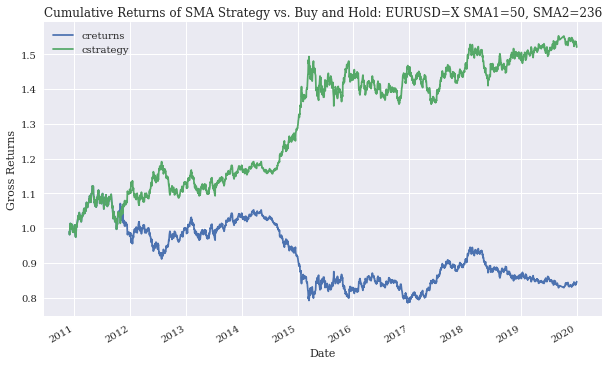

In [143]:
# you can plot the cumulative returns of the SMA strategy vs the buy and hold strategy
sma_bt.plot_results()

In [ ]:
t

2.4